PART A

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import tensorflow
import zipfile
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, Conv1D, TimeDistributed, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the data
from keras.datasets import imdb

vocab_size = 10000
# Loading the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

In [3]:
maxlen = 300

In [4]:
random_state = 42
tensorflow.random.set_seed(random_state)

In [5]:
# Padding each sentence to be of length 300
X_train = pad_sequences(x_train, maxlen = maxlen, padding = 'pre')
X_test = pad_sequences(x_test, maxlen = maxlen, padding = 'pre')

X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

In [6]:
# Number of features

In [7]:
print(f'Number of rows in training dataset: {X_train.shape[0]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(X_train)))}')

Number of rows in training dataset: 32000
Number of unique words in training dataset: 9999


In [8]:
print(f'Number of rows in validation dataset: {X_valid.shape[0]}')
print(f'Number of unique words in validation dataset: {len(np.unique(np.hstack(X_valid)))}')

Number of rows in validation dataset: 8000
Number of unique words in validation dataset: 9984


In [9]:
print(f'Number of rows in test dataset: {X_test.shape[0]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(X_test)))}')

Number of rows in test dataset: 10000
Number of unique words in test dataset: 9995


In [10]:
# Number of labels

In [11]:
print(f'Number of columns in training dataset: {X_train.shape[1]}')

Number of columns in training dataset: 300


In [12]:
print(f'Number of columns in validation dataset: {X_valid.shape[1]}')

Number of columns in validation dataset: 300


In [13]:
print(f'Number of columns in testing dataset: {X_test.shape[1]}')

Number of columns in testing dataset: 300


In [14]:
print(f'Unique categories: {np.unique(y_train), np.unique(y_valid), np.unique(y_test)}')

Unique categories: (array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64))


In [15]:
# Printing value of any one feature and label
sample_feature = X_train[4]
sample_label = y_train[4]

print("Feature:")
print(sample_feature)

print("\nLabel:")
print(sample_label)

Feature:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1   14   16  167 2653    2  840  781   12    9  179 2625    5
  287  600    7    4 3160 5177   18    4  370    5  802    2   29   62
 2444    6  171  153  303   19   27    2 4826    5    4 1761 4390 2027
   75   28    6 3993    7    2    2   17    6 1766 1582    5  107 1766
    2   37   28 1610    6 8503   11    2    2   68 5529    9    8  361
    2  278   33    4 5470 8915    5 1176    6 3200  173    7   15 1347
    9   18    4 1582 2653    2    8    2  309  200    6 5501  298    2
    5   27 6393  322    2   41    5 1383    8 3235   49  278   34  395
   23   41 5575   29  166    4 1323    7   82  656    4  113    2    7
    4 5094  937   29   47 4407    8 2275   54   59 1085   98  295   59
  732  968    8    4  673 2653    2    5   27 5254   26   23    4    2
 9910  133 2653    2   86    2   27 3570   17    4  132   25  119    8
  784   29    9 1562   78    5   27  109 1508  853  721   90    8   

In [16]:
# Decoding feature value to get original sentence
def decode_review(x, y):
  w2i = imdb.get_word_index()
  w2i = {k:(v+3) for k, v in w2i.items()}
  w2i['<PAD>'] = 0
  w2i['<START>'] = 1
  w2i['<UNK>'] = 2
  i2w = {i: w for w, i in w2i.items()}
  ws = (' '.join(i2w[i] for i in x))
  print(f'Review: {ws}')
  print(f'Actual Sentiment: {y}')
  return w2i, i2w

In [17]:
w2i, i2w = decode_review(X_train[0], y_train[0])

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> the only possible way to enjoy this flick is to bang your head against the wall allow some internal <UNK> of the brain let a bunch of your brain cells die and once you are officially mentally retarded perhaps then you might enjoy this film br br the only saving grace was the story between <UNK> and stephanie govinda was excellent in the role of the cab driver and so was the brit girl perhaps if they would have created the whole movie on their <UNK> in india and how they eventually fall in love would have made it a much more enjoyable film br br the onl

In [18]:
# Building a model
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length = maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(Conv1D(128, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(75))
model.add(Dense(1, activation = 'sigmoid'))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

# Training the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 0)
checkpoint = ModelCheckpoint('imdb_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 256)          2560000   
                                                                 
 dropout (Dropout)           (None, 300, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 256)          327936    
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          163968    
                                                                 
 max_pooling1d (MaxPooling1  (None, 150, 128)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 64)           41024     
                                                     

In [19]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 64,
                    validation_data = (X_valid, y_valid), callbacks = [early_stopping, checkpoint])

# Evaluating the model
scores = model.evaluate(X_test, y_test, batch_size = 64)
print('Test accuracy: %.2f%%' % (scores[1]*100))

Epoch 1/5


500/500 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8281
Epoch 1: val_loss improved from inf to 0.27549, saving model to imdb_model.h5
500/500 [==============================] - 924s 2s/step - loss: 0.3589 - accuracy: 0.8281 - val_loss: 0.2755 - val_accuracy: 0.8885
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9278
Epoch 2: val_loss improved from 0.27549 to 0.25088, saving model to imdb_model.h5
500/500 [==============================] - 820s 2s/step - loss: 0.1878 - accuracy: 0.9278 - val_loss: 0.2509 - val_accuracy: 0.8988
Epoch 3/5
500/500 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9527
Epoch 3: val_loss did not improve from 0.25088
500/500 [==============================] - 613s 1s/step - loss: 0.1325 - accuracy: 0.9527 - val_loss: 0.2734 - val_accuracy: 0.8911
Epoch 3: early stopping
157/157 [==============================] - 26s 156ms/step - loss: 0.2635 - accuracy: 0

In [20]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(f'Classification Report:\n{classification_report(y_pred_classes, y_test)}')

313/313 [==============================] - 28s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4510
           1       0.94      0.87      0.90      5490

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000




 Confusion matrix:
 [[4193  719]
 [ 317 4771]]


Text(0.5, 1.0, 'Confusion Matrix HeatMap')

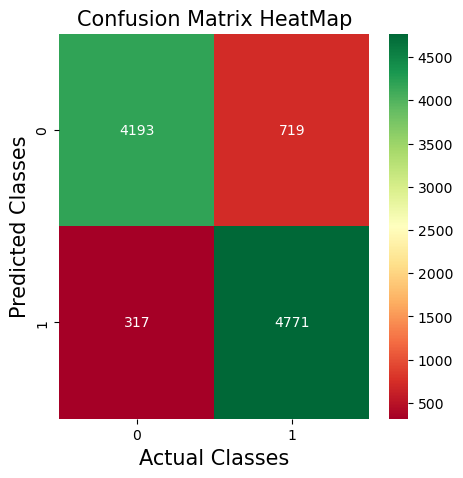

In [21]:
cfm_lstm = confusion_matrix(y_test, y_pred_classes)
print('\n Confusion matrix:\n', cfm_lstm)

plt.figure(figsize = (5, 5))
sns.heatmap(cfm_lstm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15)

In [22]:
# Retrive output of each layer in keras for a given single test sample from the trained model
sample_x_test = X_test[np.random.randint(10000)]
for layer in model.layers:

    model_layer = Model(inputs = model.input, outputs = model.get_layer(layer.name).output)
    output = model_layer.predict(sample_x_test.reshape(1,-1))
    print('\n','--'*20, layer.name, 'layer', '--'*20, '\n')
    print(output)

1/1 [==============================] - 0s 78ms/step

 ---------------------------------------- embedding layer ---------------------------------------- 

[[[ 0.00839722  0.01627486 -0.01125092 ...  0.02336924 -0.0058644
    0.0387612 ]
  [ 0.00839722  0.01627486 -0.01125092 ...  0.02336924 -0.0058644
    0.0387612 ]
  [ 0.00839722  0.01627486 -0.01125092 ...  0.02336924 -0.0058644
    0.0387612 ]
  ...
  [-0.04055499  0.01933148  0.0682769  ...  0.03541138  0.0449774
    0.02380893]
  [-0.00782218 -0.00788104  0.01514681 ... -0.0746735   0.01337895
    0.01314029]
  [-0.0956591  -0.05286961 -0.03807113 ...  0.06982388  0.06455754
   -0.06815812]]]
1/1 [==============================] - 0s 87ms/step

 ---------------------------------------- dropout layer ---------------------------------------- 

[[[ 0.00839722  0.01627486 -0.01125092 ...  0.02336924 -0.0058644
    0.0387612 ]
  [ 0.00839722  0.01627486 -0.01125092 ...  0.02336924 -0.0058644
    0.0387612 ]
  [ 0.00839722  0.01627486 -

In [23]:
# Printing prediction of any one sample
decode_review(x_test[10], y_test[10])
print(f'Predicted sentiment: {y_pred[10][0]}')

Review: <START> inspired by hitchcock's strangers on a train concept of two men <UNK> murders in exchange for getting rid of the two people messing up their lives throw <UNK> from the train is an original and very inventive comedy take on the idea it's a credit to danny <UNK> that he both wrote and starred in this minor comedy gem br br anne <UNK> is the mother who <UNK> the film's title and it's understandable why she gets under the skin of danny <UNK> with her sharp tongue and relentlessly putting him down for any minor <UNK> billy crystal is the writer who's wife has stolen his book idea and is now being <UNK> as a great new author even appearing on the oprah show to in <UNK> he should be enjoying thus <UNK> gets the idea of <UNK> murders to rid themselves of these <UNK> factors br br of course everything and anything can happen when writer carl <UNK> lets his imagination <UNK> with <UNK> ideas for how the plot develops and it's amusing all the way through providing plenty of laughs

PART B

In [24]:
# Importing packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud

from zipfile import ZipFile
import os

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [25]:
data = pd.read_json("C:/Users/ruhee/OneDrive/Desktop/AIML/Natural Language Processing/Sarcasm_Headlines_Dataset.json", lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. The first five headlines in the dataset along with their category are:')
data.head()

Data has 28619 rows and 3 columns. The first five headlines in the dataset along with their category are:


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [26]:
glove_file = "C:/Users/ruhee/OneDrive/Desktop/AIML/Natural Language Processing/glove.6B.zip"
extract_folder = "C:/Users/ruhee/OneDrive/Desktop/AIML/Natural Language Processing/PART B"

with ZipFile(glove_file, 'r') as z:
  z.extractall(extract_folder)
file_path = os.path.join(extract_folder, 'glove.6B.300d.txt')

with open(file_path, encoding = "utf8") as f:
    embeddings = {}
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector

In [27]:
len(data)

28619

In [28]:
len(embeddings)

400000

In [29]:
data.shape

(28619, 3)

In [30]:
embeddings['word'].shape

(300,)

In [31]:
sarcastic_count = data[data.is_sarcastic == 1].shape[0]
non_sarcastic_count = data[data.is_sarcastic == 0].shape[0]
print(sarcastic_count)
print(non_sarcastic_count)

13634
14985


In [32]:
sarcastic_percentage = round(sarcastic_count / data.shape[0] * 100, 0)
non_sarcastic_percentage = round(non_sarcastic_count / data.shape[0] * 100, 0)
print(sarcastic_percentage)
print(non_sarcastic_percentage)

48.0
52.0


In [33]:
hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-Sarcastic']))

,huffingtonpost,theonion
Sarcastic,0,13634
Non-Sarcastic,14985,1


In [34]:
# Retaining relevant columns (Dropping columns that are irrelevant)
data.drop('article_link', axis = 1, inplace = True)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [35]:
# Function to remove punctuations
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' 
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', punct))

# Function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  return ''.join([lemmatizer.lemmatize(word) for word in text])

In [36]:
# Converting headlines to lower case
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())
# Removing punctuations
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))
# Applying Lemmatizer
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lemmatize(x))

In [37]:
# Length of each sentence
data['length_of_sentence'] = data['cleaned_headline'].apply(lambda x: len(x.split()))
data

,is_sarcastic,headline,cleaned_headline,length_of_sentence
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling ...,13
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word stream...,9
...,...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,jews to celebrate rosh hashasha or something,7
28615,1,internal affairs investigator disappointed con...,internal affairs investigator disappointed con...,13
28616,0,the most beautiful acceptance speech this week...,the most beautiful acceptance speech this week...,12
28617,1,mars probe destroyed by orbiting spielberg-gat...,mars probe destroyed by orbiting spielberggate...,8


In [38]:
# Defining parameters
embedding_size = 300
max_len = data['length_of_sentence'].max()
vocab_size = len(set(' '.join(data['cleaned_headline']).split()))

In [39]:
print(embedding_size)
print(max_len)
print(vocab_size)

300
151
29667


In [40]:
# Using Tokenizer to get indices for words
tokenizer = Tokenizer(num_words = vocab_size) 
tokenizer.fit_on_texts(data['cleaned_headline'])
word_indices = tokenizer.word_index
print("Word Indices-", word_indices)

Word Indices- {'to': 1, 'of': 2, 'the': 3, 'in': 4, 'for': 5, 'a': 6, 'on': 7, 'and': 8, 'with': 9, 'is': 10, 'new': 11, 'trump': 12, 'man': 13, 'from': 14, 'at': 15, 'about': 16, 'you': 17, 'by': 18, 'after': 19, 'this': 20, 'be': 21, 'out': 22, 'that': 23, 'as': 24, 'it': 25, 'how': 26, 'up': 27, 'not': 28, 'he': 29, 'his': 30, 'are': 31, 'just': 32, 'what': 33, 'your': 34, 'who': 35, 'has': 36, 'all': 37, 'will': 38, 'report': 39, 'us': 40, 'more': 41, 'into': 42, 'one': 43, 'have': 44, 'over': 45, 'why': 46, 'woman': 47, 'area': 48, 'can': 49, 'says': 50, 'day': 51, 'donald': 52, 'time': 53, 'no': 54, 'its': 55, 'like': 56, 'first': 57, 'get': 58, 'her': 59, 'trumps': 60, 'people': 61, 'now': 62, 'house': 63, 'an': 64, 'i': 65, 'off': 66, 'life': 67, 'still': 68, 'white': 69, 'obama': 70, 'make': 71, 'was': 72, 'back': 73, 'than': 74, 'if': 75, 'women': 76, 'down': 77, 'my': 78, 'when': 79, 'we': 80, 'clinton': 81, 'could': 82, 'they': 83, 'years': 84, 'their': 85, 'before': 86, 'w

In [41]:
# Creating features and labels
max_features = 10000
max_len = 25
embedding_size = 300
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = max_len)
y = np.asarray(data['is_sarcastic'])

print(f'Number of samples: {len(X)}')
print(f'Number of samples: {len(y)}')
print(f'\nFirst Headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of samples: 28619
Number of samples: 28619

First Headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  336 3106 6323 2319    2  671 1138]

Label of the first headline: 1


In [42]:
# Vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_headline'])
vocab_size = len(tokenizer.word_index)
print("Vocabulary Size -", vocab_size)

Vocabulary Size - 29681


In [43]:
# Creating a weight matrix using GloVe embeddings
embedding_matrix = np.zeros((vocab_size + 1, embedding_size))  
for word, i in word_indices.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Weight Matrix using GloVe Embeddings-")
print(embedding_matrix)
print("Shape of Weight Matrix-", embedding_matrix.shape)

Weight Matrix using GloVe Embeddings-
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.25756001 -0.057132   -0.67189997 ... -0.16043     0.046744
  -0.070621  ]
 [-0.076947   -0.021211    0.21270999 ...  0.18351001 -0.29183
  -0.046533  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.32249999 -0.055406    0.45530999 ... -0.71302003 -0.37112001
  -0.1903    ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Shape of Weight Matrix- (29682, 300)


In [44]:
# Defining a model
def create_model():
    model = Sequential([
                      Embedding(input_dim = vocab_size + 1, output_dim = embedding_size,
                                weights = [embedding_matrix],
                                input_length = max_len, trainable = False),
                      Bidirectional(LSTM(512, return_sequences = True)),
                      GlobalMaxPool1D(),
                      Dense(256, activation = 'relu'),
                      Dropout(0.5, input_shape = (256,)),
                      Dense(128, activation = 'relu'),
                      Dropout(0.5, input_shape = (128, )),
                      Dense(64, activation = 'relu'),
                      Dropout(0.5, input_shape = (64, )),
                      Flatten(),
                      Dense(1, activation = 'sigmoid')])

    return model

In [45]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 300)           8904600   
                                                                 
 bidirectional (Bidirection  (None, 25, 1024)          3330048   
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 1024)              0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [46]:
# Compiling the model
init_lr = 1e-4
epochs = 10
optimizer = Adam(learning_rate = init_lr)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [47]:
batch_size = 50

In [48]:
# Fitting the model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 50)
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/10
458/458 [==============================] - 169s 353ms/step - loss: 0.6241 - accuracy: 0.6351
Epoch 2/10
458/458 [==============================] - 162s 354ms/step - loss: 0.4691 - accuracy: 0.7896
Epoch 3/10
458/458 [==============================] - 161s 351ms/step - loss: 0.3999 - accuracy: 0.8283
Epoch 4/10
458/458 [==============================] - 162s 353ms/step - loss: 0.3461 - accuracy: 0.8557
Epoch 5/10
458/458 [==============================] - 159s 347ms/step - loss: 0.2976 - accuracy: 0.8812
Epoch 6/10
458/458 [==============================] - 159s 347ms/step - loss: 0.2486 - accuracy: 0.9068
Epoch 7/10
458/458 [==============================] - 161s 351ms/step - loss: 0.2007 - accuracy: 0.9254
Epoch 8/10
458/458 [==============================] - 159s 346ms/step - loss: 0.1551 - accuracy: 0.9458
Epoch 9/10
458/458 [==============================] - 159s 346ms/step - loss: 0.1110 - accuracy: 0.9626
Epoch 10/10
458/458 [==============================] - 159s 348m

In [49]:
# Validation Loss and Validation Accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print("Validation Loss-", val_loss)
print("Validation Accuracy-", val_accuracy)

179/179 [==============================] - 12s 61ms/step - loss: 0.4659 - accuracy: 0.8653
Validation Loss- 0.46591201424598694
Validation Accuracy- 0.8653039932250977
